<a href="https://colab.research.google.com/github/longaresf/prediccion_de_precios_de_vehiculos_usados/blob/main/Francisco_Longares_Prediccion_de_Precios_de_Vehiculos_Usados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Librerias a importar
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [4]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#1. Carga y Exploración de Datos:
Cargar el dataset

In [5]:
# Importar DataFrame
path = '/content/drive/MyDrive/Colab Notebooks/Modelos Regresión/dataset/vehicles.csv'
data = pd.read_csv(path)

Realizar una exploración inicial para entender la estructura del dataset

In [ ]:
# Exploración de datos
print(data.head())
print(data.describe())

           id                                                url  \
0  7222695916  https://prescott.craigslist.org/cto/d/prescott...   
1  7218891961  https://fayar.craigslist.org/ctd/d/bentonville...   
2  7221797935  https://keys.craigslist.org/cto/d/summerland-k...   
3  7222270760  https://worcester.craigslist.org/cto/d/west-br...   
4  7210384030  https://greensboro.craigslist.org/cto/d/trinit...   

                   region                         region_url  price  year  \
0                prescott    https://prescott.craigslist.org   6000   NaN   
1            fayetteville       https://fayar.craigslist.org  11900   NaN   
2            florida keys        https://keys.craigslist.org  21000   NaN   
3  worcester / central MA   https://worcester.craigslist.org   1500   NaN   
4              greensboro  https://greensboro.craigslist.org   4900   NaN   

  manufacturer model condition cylinders  ... size  type paint_color  \
0          NaN   NaN       NaN       NaN  ...  NaN   NaN

Identificar valores faltantes

In [6]:
# Hacemos copia del DataFrame
df=data.copy()

# Convertimos a minúsculas las columnas
df.columns = df.columns.str.lower().str.strip()

# Verificar por datos nulos o NaN
datos_null = df.isnull()
if datos_null.any().any():
    print("Cantidad de datos nulos por columna:\n", datos_null.sum())
else:
    print("No se encontró datos nulos")

Cantidad de datos nulos por columna:
 id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
vin             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64


Identificar valores duplicados

In [ ]:
# Buscar datos duplicados
datos_duplicados = df.duplicated()
if datos_duplicados.any():
    print("Cantidad de datos duplicados: ", datos_duplicados.sum())
else:
    print("No se encontró datos duplicados")

No se encontró datos duplicados


Identificar valores outliers

In [ ]:
# Detectar valores extremos o fuera de rango segun interpretacion de las columnas
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [ ]:
# Función para identificar valores outliers usando el método IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identificar outliers en columna numéricas
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

print("\nIdentificar outliers usando el método IQR:")
for col in numerical_columns:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        print(f"Outliers en columna '{col}':")
        print(outliers[[col]])
        print("-" * 30)


Identificar outliers usando el método IQR:
Outliers en columna 'id':
                id
0       7222695916
1       7218891961
2       7221797935
3       7222270760
4       7210384030
5       7222379453
6       7221952215
7       7220195662
8       7209064557
9       7219485069
10      7218893038
11      7218325704
12      7217788283
13      7217147606
14      7209027818
15      7223509794
16      7222753076
17      7222206015
18      7220030122
19      7218423006
20      7216672204
21      7215617048
22      7213839225
23      7208549803
24      7213843538
25      7212631321
26      7219973522
70037   7271652768
72478   7253221350
80766   7220458944
80767   7217189206
80768   7216549243
80769   7215547569
144406  7274801461
159273  7207408119
175630  7276457699
295053  7220463904
295054  7216610223
295055  7216610120
295056  7216603380
295057  7212512589
295058  7209054699
331001  7293026056
402274  7291716547
------------------------------
Outliers en columna 'price':
            pri

Identificar valores únicos

In [ ]:
# Verificamos valores únicos en las columas
for col in df.columns:
    print(f"\nDatos en la columa: '{col}':")
    print(df[col].unique())


Datos en la columa: 'id':
[7222695916 7218891961 7221797935 ... 7301591147 7301591140 7301591129]

Datos en la columa: 'url':
['https://prescott.craigslist.org/cto/d/prescott-2010-ford-ranger/7222695916.html'
 'https://fayar.craigslist.org/ctd/d/bentonville-2017-hyundai-elantra-se/7218891961.html'
 'https://keys.craigslist.org/cto/d/summerland-key-2005-excursion/7221797935.html'
 ...
 'https://wyoming.craigslist.org/ctd/d/atlanta-2020-caddy-cadillac-xt4-sport/7301591147.html'
 'https://wyoming.craigslist.org/ctd/d/atlanta-2018-lexus-es-es-350-sedan-4d/7301591140.html'
 'https://wyoming.craigslist.org/ctd/d/atlanta-2019-bmw-series-430i-gran-coupe/7301591129.html']

Datos en la columa: 'region':
['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'mo

Verificar tipos de datos en columnas

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  vin           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

#2. Limpieza y Preprocesamiento:

Eliminar columnas innecesarias y sobre 50% de datos nulos

In [7]:
# Eliminar columnas innecesarias
df = df.drop(['id', 'url', 'region_url', 'vin', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date'], axis=1, inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   title_status  418638 non-null  object 
 10  transmission  424324 non-null  object 
 11  drive         296313 non-null  object 
 12  size          120519 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 52.1+ MB


In [8]:
# Eliminar columnas con muchos valores faltantes
for col in df.columns:
  if col in df.columns and df[col].isnull().sum() > len(df) * 0.5:
      df.drop(col, axis=1)
      print(f"\nColumna '{col}' eliminada debido a la alta cantidad de valores faltantes.")


Columna 'size' eliminada debido a la alta cantidad de valores faltantes.


Modificar tipo de datos de columnas

In [9]:
# Cambiamos tipo de dato de columnas 'year' y 'odometer' a integer.
# Rellenamos los datos nulos con '0'
df['year'] = df['year'].fillna(0).astype(int)
df['odometer'] = df['odometer'].fillna(0).astype(int)

# Verificar los cambios
print(df['year'].dtype)
print(df['odometer'].dtype)

int64
int64


Manejar valores faltantes

In [10]:
# Manejar valores faltantes
for col in df.columns:
    if df[col].isnull().any() or (df[col] == 0).any():
        if df[col].dtype == 'object':
            # Si es categórica, rellenar con la moda
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
        else:
            # Si es numérica, rellenar con el promedio y reemplazar los ceros con el promedio
            mean_value = df[col].mean()
            df[col] = df[col].fillna(mean_value)
            # Reemplazar los ceros con el promedio.
            df[col] = df[col].replace(0, mean_value)

# Verificar si quedan valores nulos o ceros en las columnas numéricas
print("Cantidad de datos nulos después de rellenar y reemplazar ceros:")
print(df.isnull().sum())

print("\nCantidad de ceros por columna numérica después de reemplazar:")
numerical_columns_after = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_columns_after:
    print(f"Columna '{col}': {(df[col] == 0).sum()} ceros")

print("\nVerificar las primeras filas del DataFrame después de la limpieza:")
print(df.head())

Cantidad de datos nulos después de rellenar y reemplazar ceros:
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

Cantidad de ceros por columna numérica después de reemplazar:
Columna 'price': 0 ceros
Columna 'year': 0 ceros
Columna 'odometer': 0 ceros

Verificar las primeras filas del DataFrame después de la limpieza:
                   region    price         year manufacturer  model condition  \
0                prescott   6000.0  2005.557862         ford  f-150      good   
1            fayetteville  11900.0  2005.557862         ford  f-150      good   
2            florida keys  21000.0  2005.557862         ford  f-150      good   
3  worcester / central MA   1500.0  2005.557862         ford  f-150      good   
4              greensb

Eliminar duplicados

In [11]:
# Buscar datos duplicados
datos_duplicados = df.duplicated()
if datos_duplicados.any():
    print("Cantidad de datos duplicados: ", datos_duplicados.sum())
    df = df.drop_duplicates()
    print("Duplicados eliminados")
else:
    print("No se encontró datos duplicados")

Cantidad de datos duplicados:  56562
Duplicados eliminados


Manejar valores outliers


Visualizar outliers después de tratar con Box Plots:


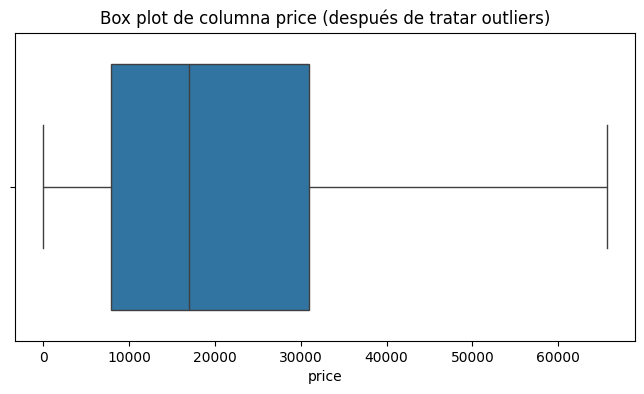

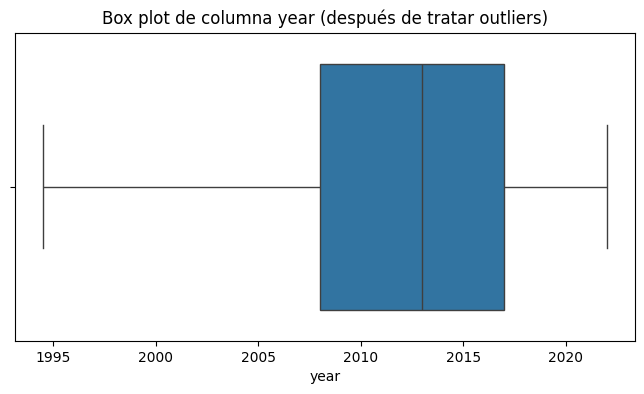

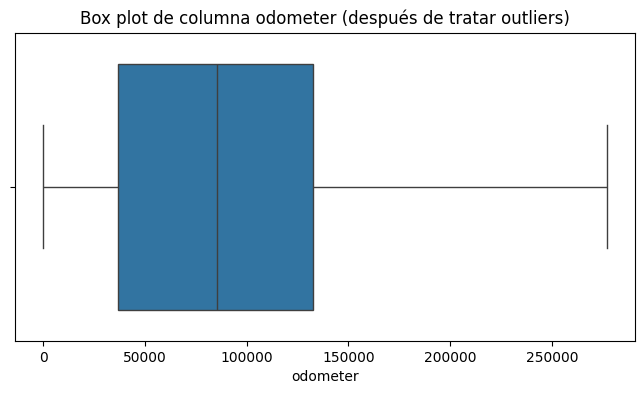

In [12]:
# Reemplazar los outliers identificados por el límite superior/inferior definido por el método IQR
def replace_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Identificar outliers en columna numéricas
numerical_columns = df.select_dtypes(include=np.number).columns.tolist()

# Aplicar la función para reemplazar outliers en las columnas numéricas
for col in numerical_columns:
    df = replace_outliers_iqr(df, col)

# Verificar si se han tratado los outliers visualizando de nuevo con box plots
print("\nVisualizar outliers después de tratar con Box Plots:")
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot de columna {col} (después de tratar outliers)')
    plt.show()


Corregir inconsistencias en los datos categóricos

In [13]:
# Convertimos a minúsculas y quitamos espacios en blanco de las columnas de tipo objeto
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = df[col].str.lower().str.strip()
    print(f"\nDatos en columna '{col}' modificada")


Datos en columna 'region' modificada

Datos en columna 'manufacturer' modificada

Datos en columna 'model' modificada

Datos en columna 'condition' modificada

Datos en columna 'cylinders' modificada

Datos en columna 'fuel' modificada

Datos en columna 'title_status' modificada

Datos en columna 'transmission' modificada

Datos en columna 'drive' modificada

Datos en columna 'size' modificada

Datos en columna 'type' modificada

Datos en columna 'paint_color' modificada

Datos en columna 'state' modificada


Uso de ColumnTransformer y Pipeline

In [14]:
# Cargar el conjunto de datos
X = df.drop('price', axis=1)
y = df['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Seleccionar columnas numéricas para escalar
# Obtener una lista de los nombres de las columnas con tipos de datos numéricos.
numeric_features = df.select_dtypes(include=np.number).columns.tolist()

# Eliminar la columna 'price' de la lista de características numéricas, ya que es la variable objetivo
if 'price' in numeric_features:
    numeric_features.remove('price')

# Identificar las columnas categóricas
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Crear transformadores para cada subconjunto de columnas
# Escalar las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Realizar transformaciones necesarias para las características categóricas
# Usar OneHotEncoder para variables nominales
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Crear un ColumnTransformer
# Aplicar los transformadores a las columnas correspondientes
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

Crear visualizaciones univariadas y multivariadas


Visualizaciones Univariadas - Histogramas para variables numéricas:


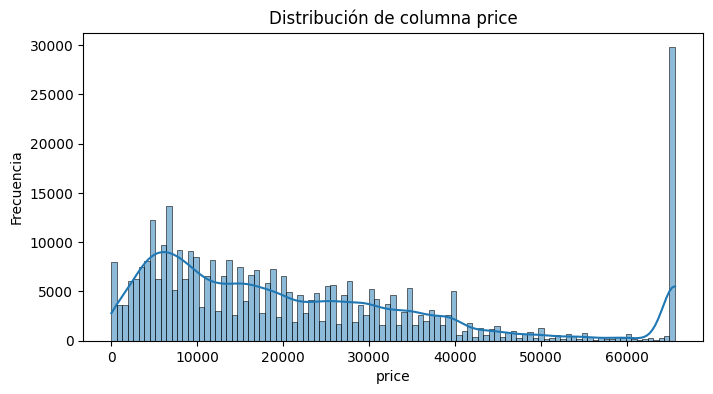

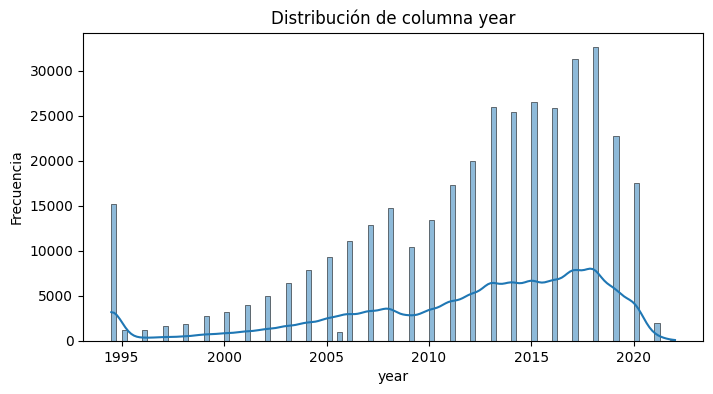

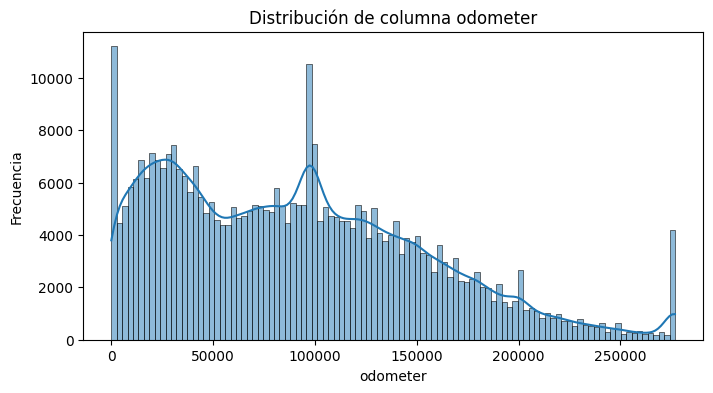


Visualizaciones Univariadas - Gráficos de barras para variables categóricas:


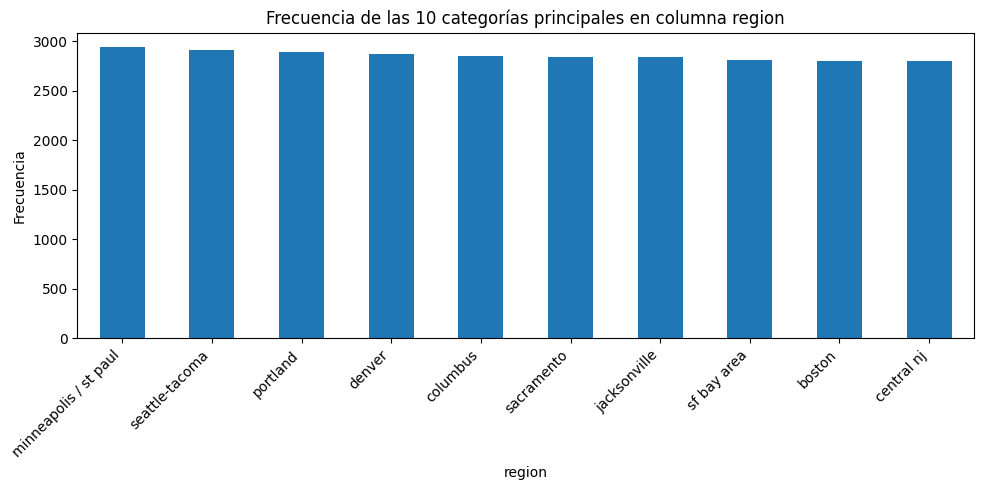

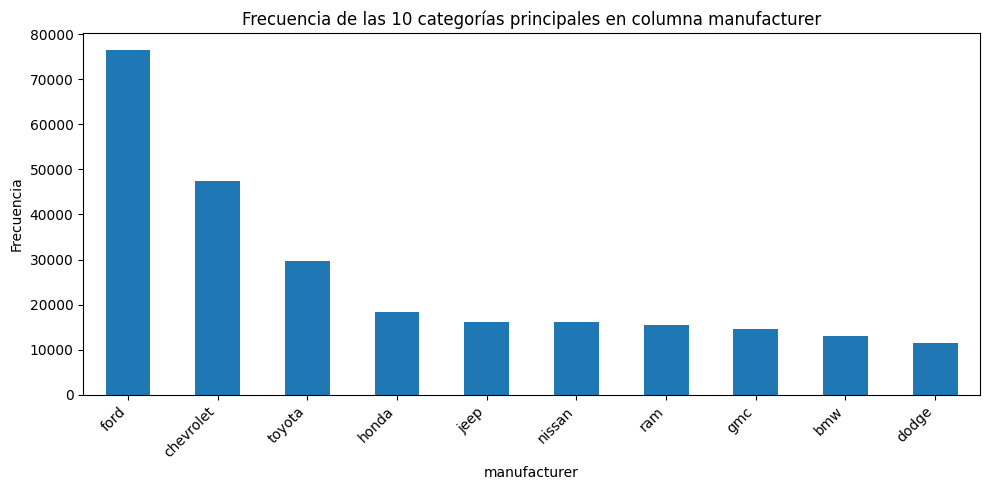

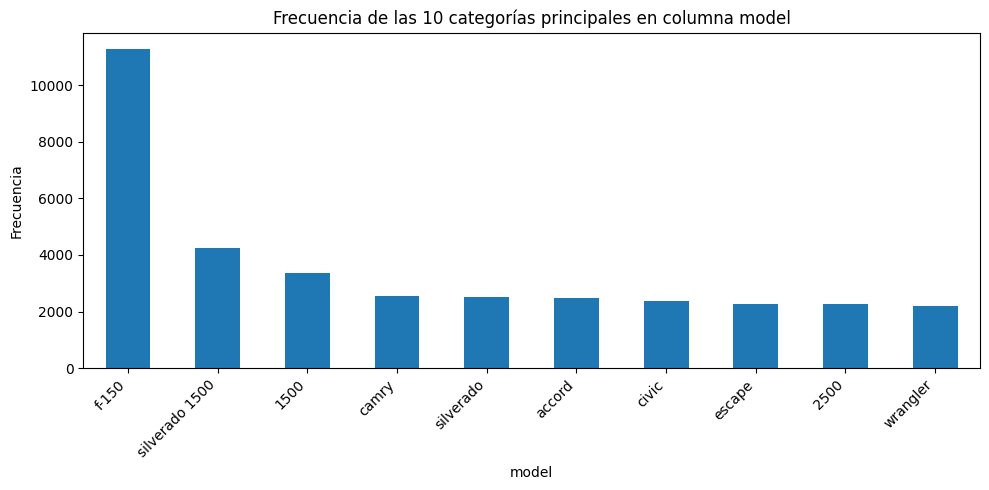

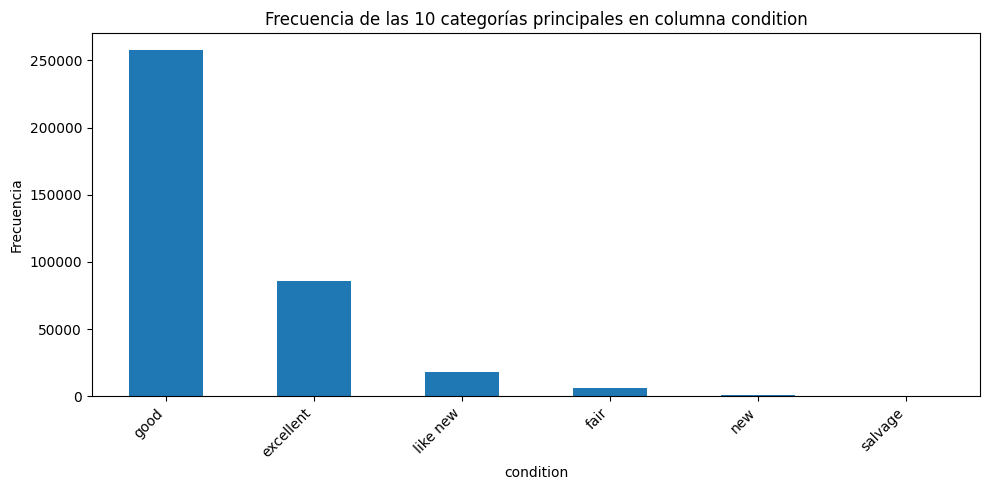

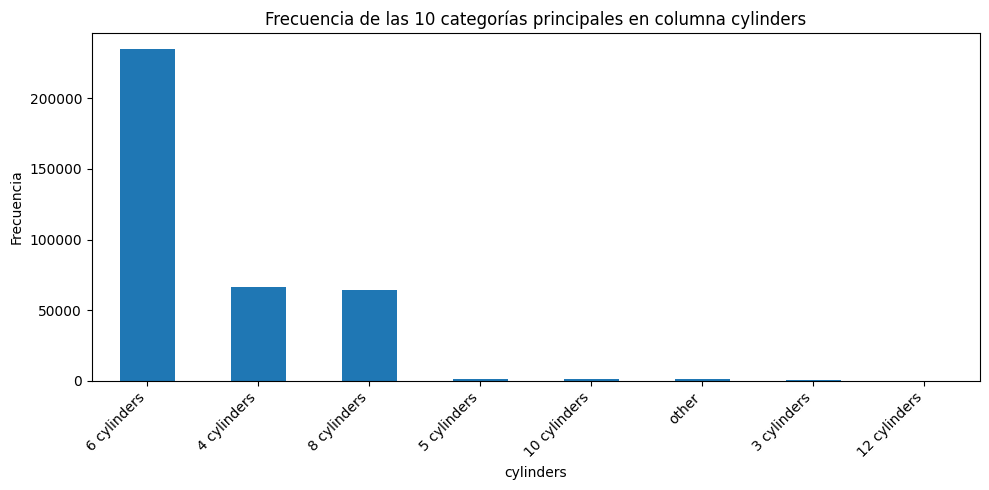

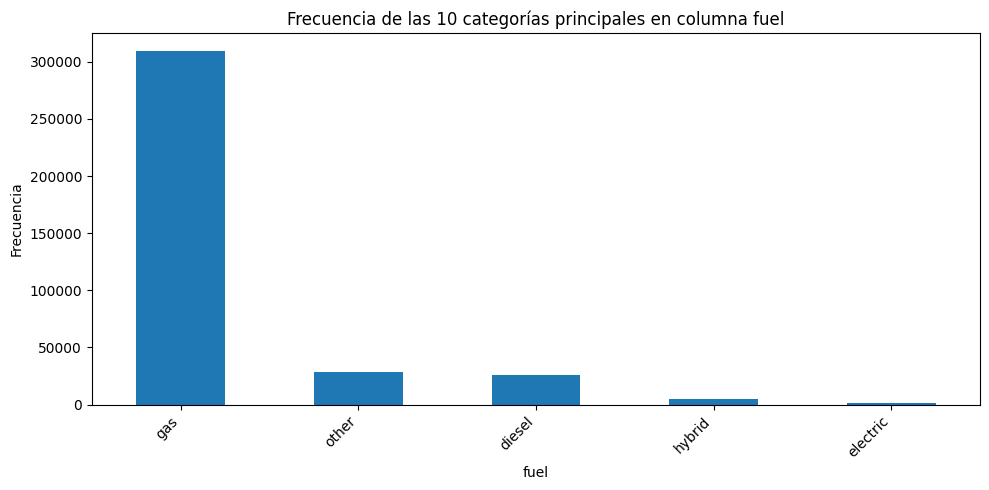

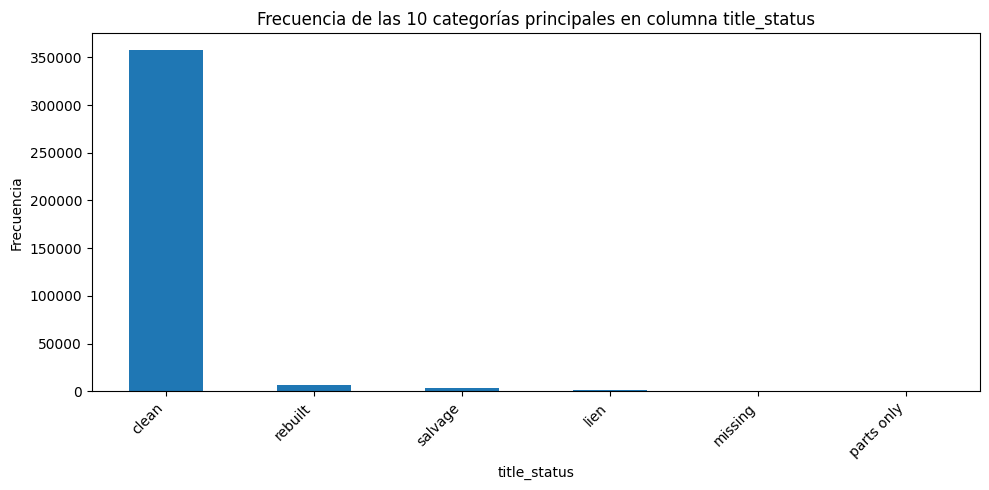

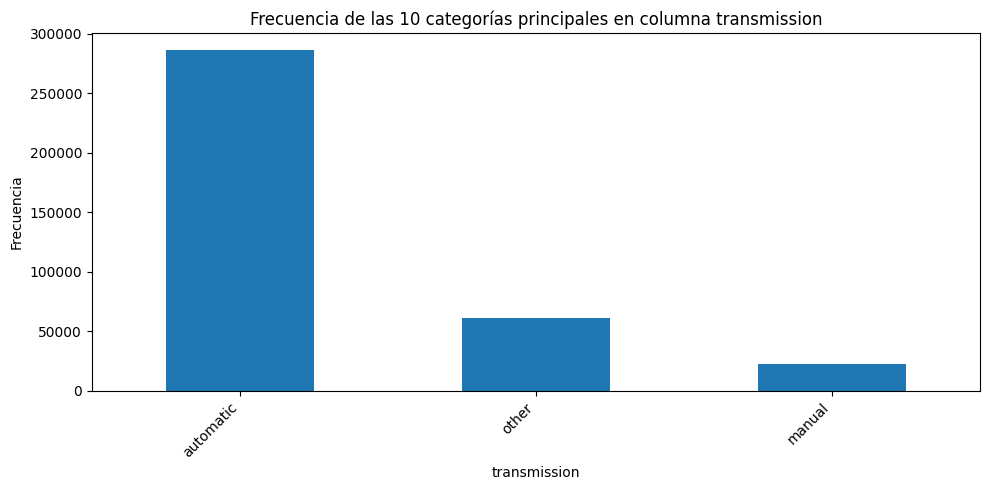

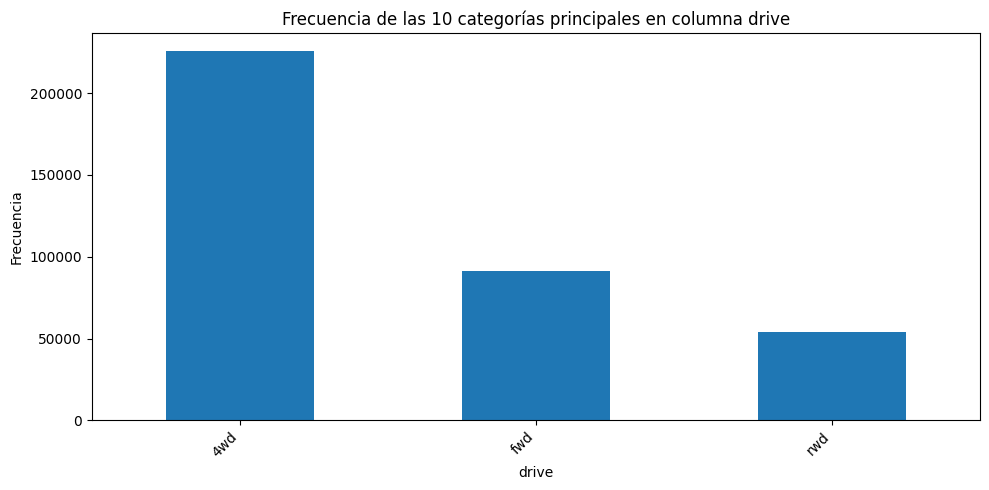

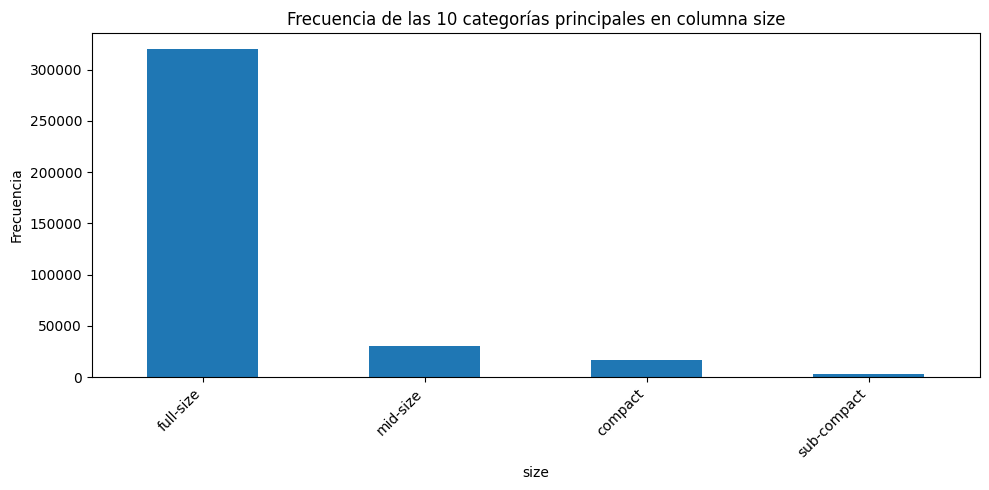

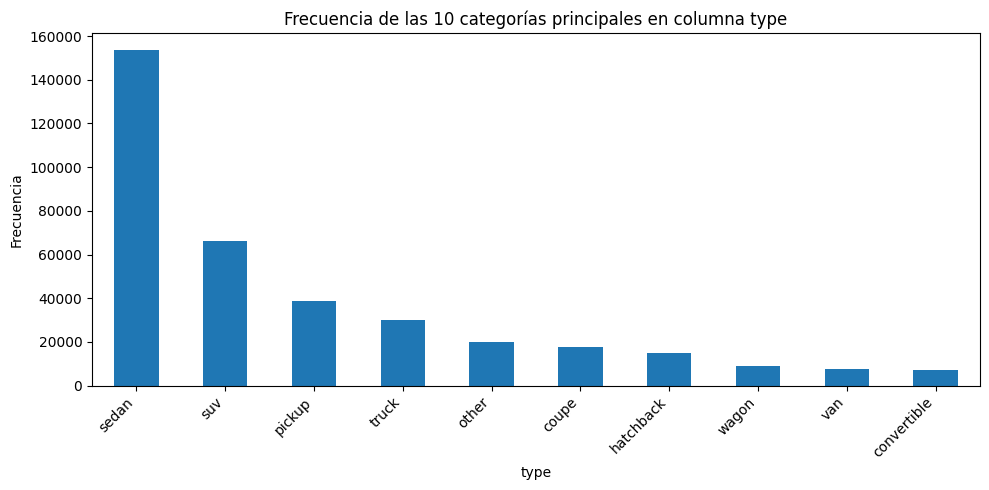

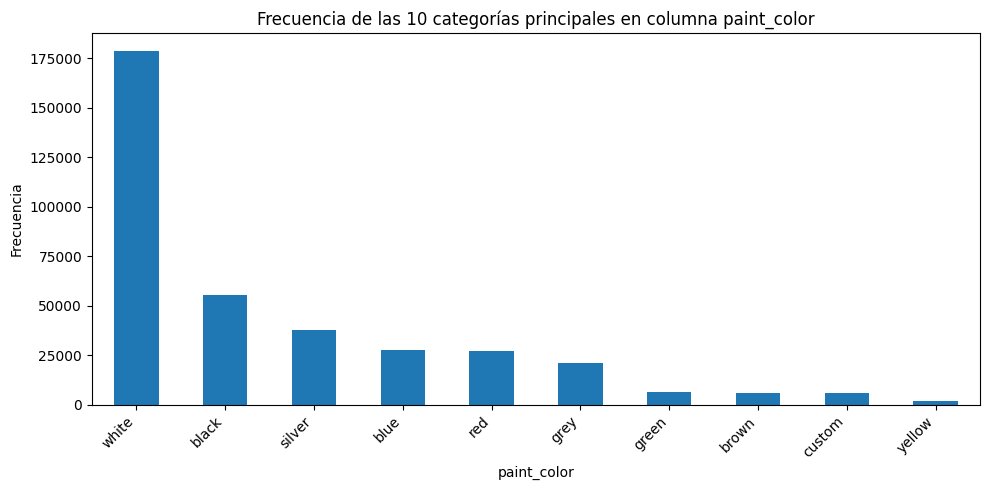

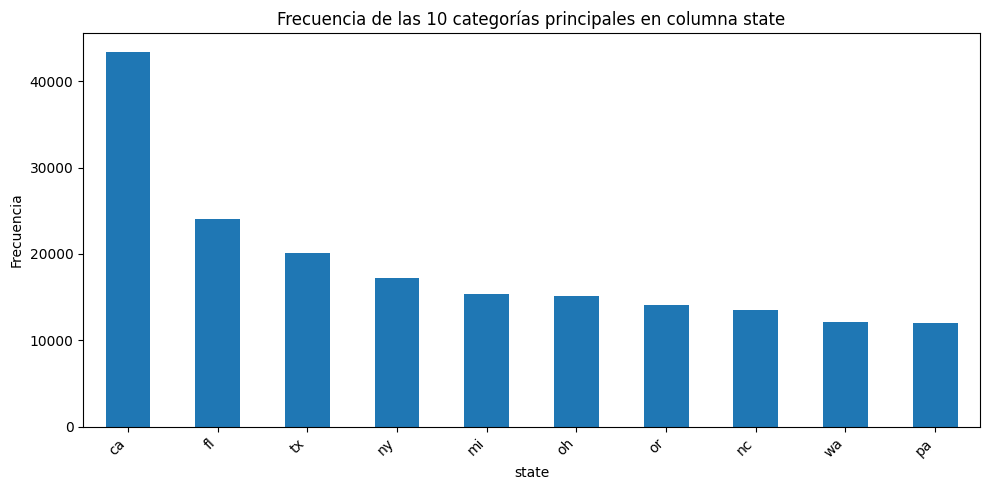


Visualizaciones Multivariadas - Matriz de correlación:


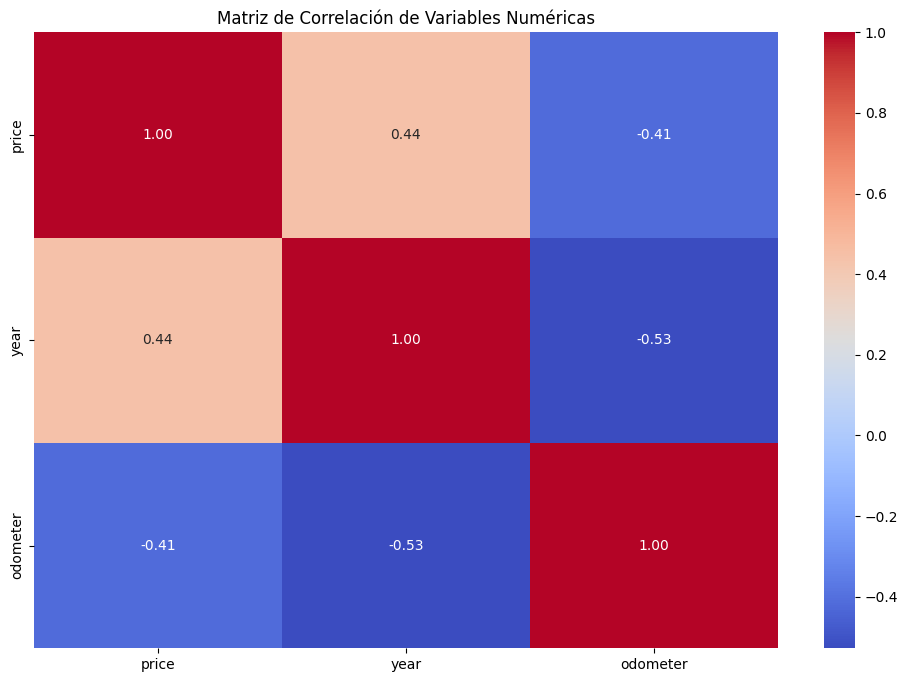


Visualizaciones Multivariadas - Box plots de 'price' vs. Variables Categóricas:


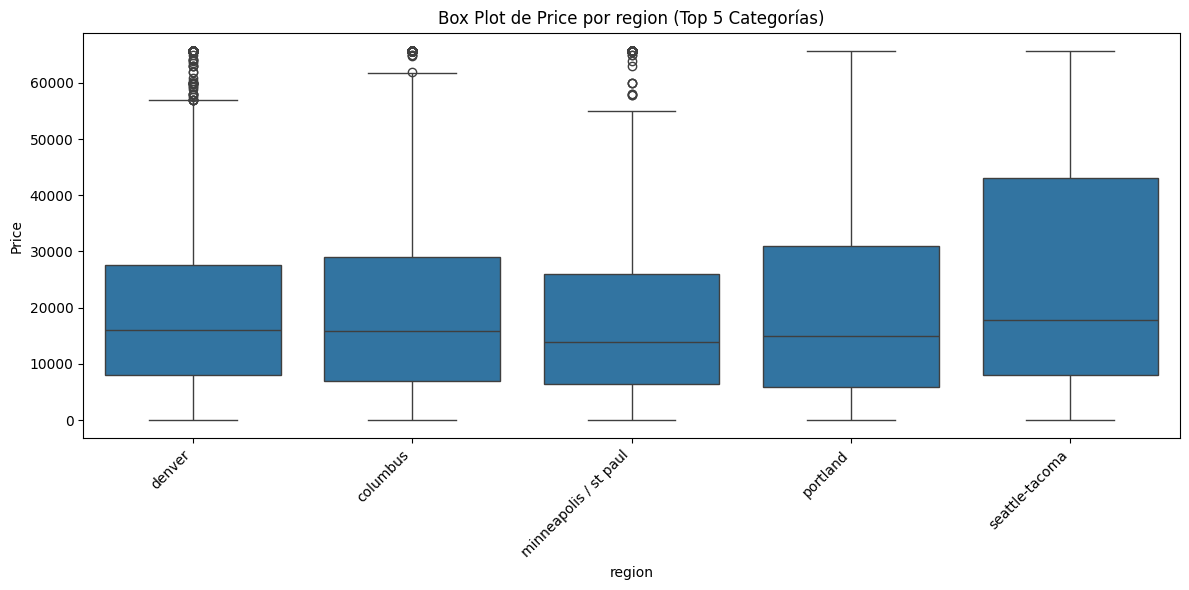

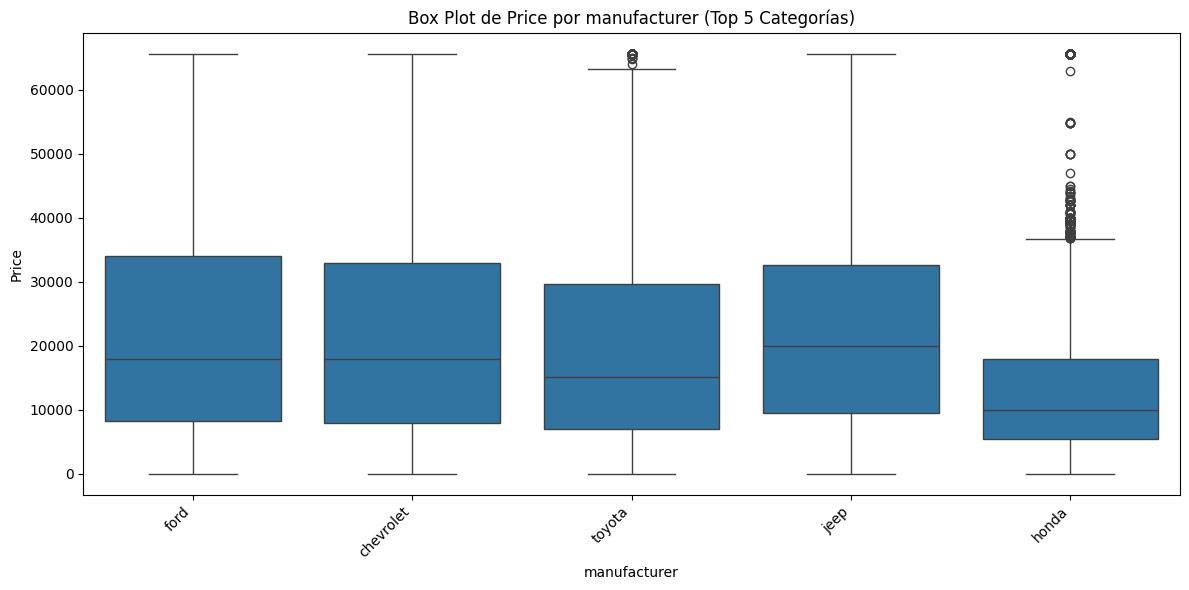

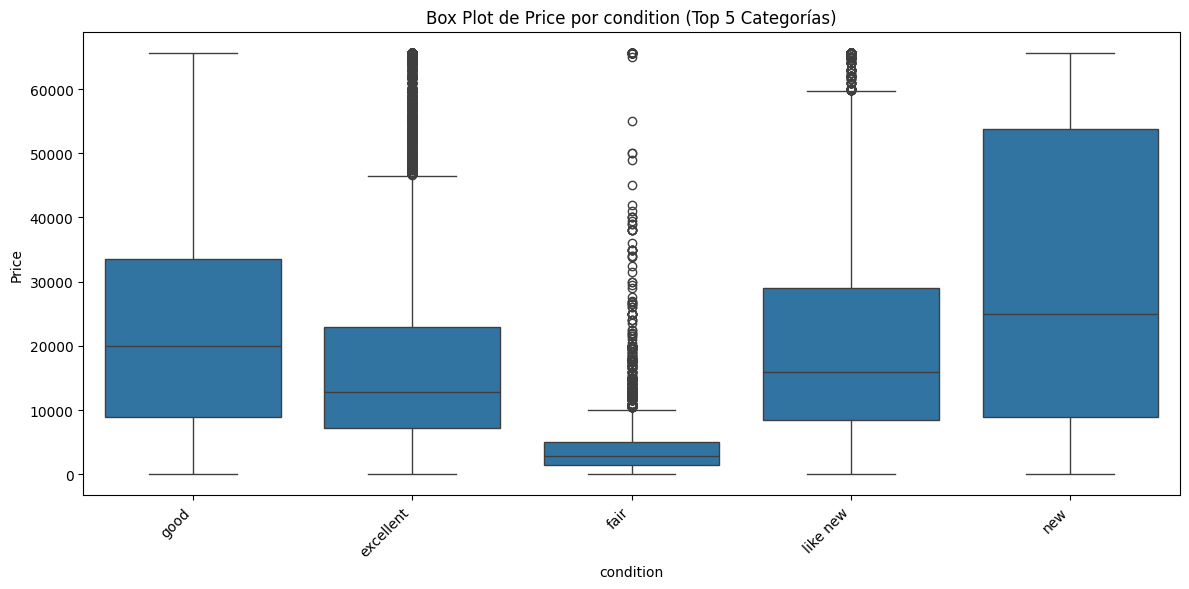

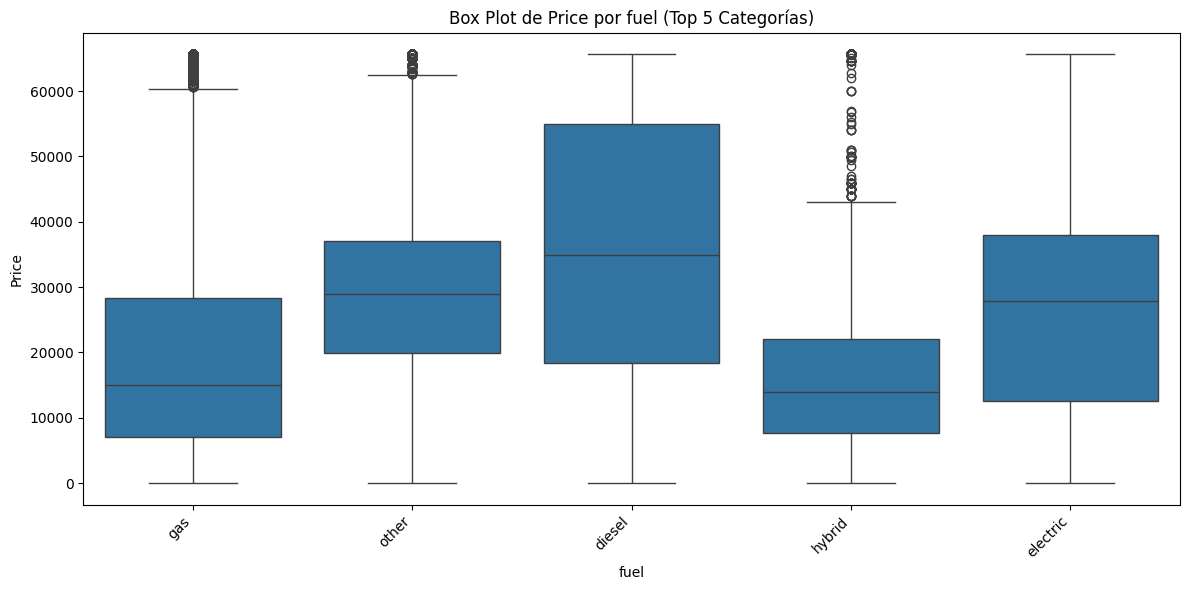

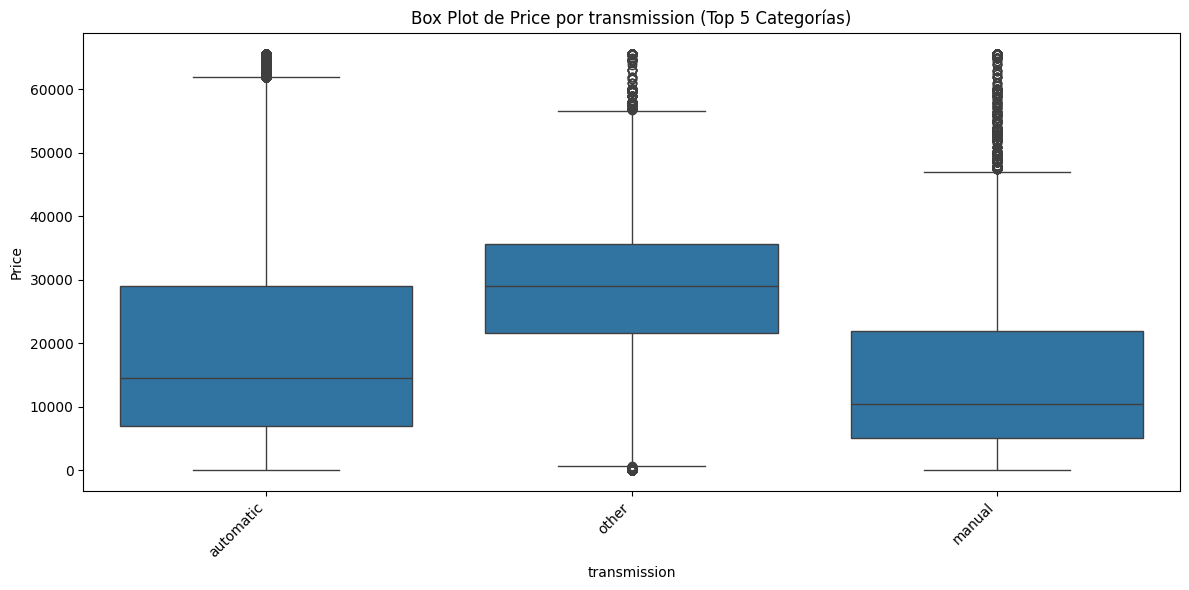


Visualizaciones Multivariadas - Scatter plots de 'price' vs. Variables Numéricas:


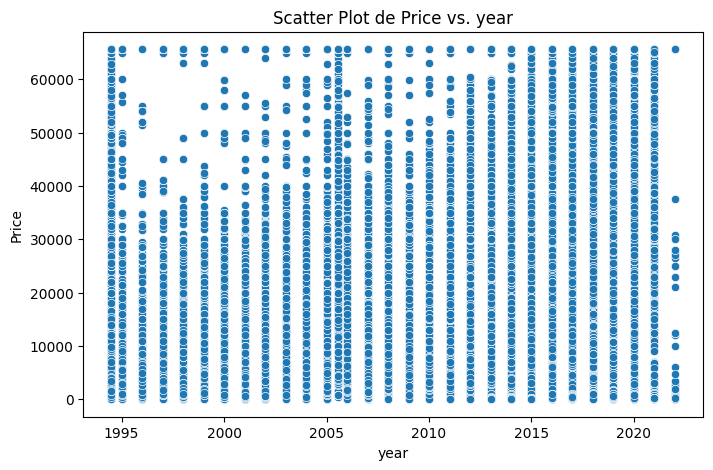

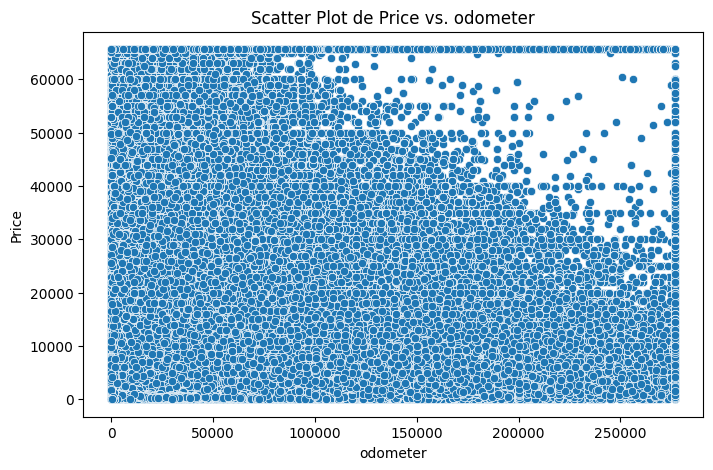

In [ ]:
# Visualizaciones Univariadas
# Histogramas para variables numéricas
print("\nVisualizaciones Univariadas - Histogramas para variables numéricas:")
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de columna {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

print("\nVisualizaciones Univariadas - Gráficos de barras para variables categóricas:")
for col in categorical_features:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().nlargest(10).plot(kind='bar')
    plt.title(f'Frecuencia de las 10 categorías principales en columna {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Visualizaciones Multivariadas
# Matriz de correlación para variables numéricas
print("\nVisualizaciones Multivariadas - Matriz de correlación:")
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# Box plots de 'price' contra algunas variables categóricas
print("\nVisualizaciones Multivariadas - Box plots de 'price' vs. Variables Categóricas:")
categorical_cols_for_boxplot = ['region', 'manufacturer', 'condition', 'fuel', 'transmission']
for col in categorical_cols_for_boxplot:
    plt.figure(figsize=(12, 6))
    top_categories = df[col].value_counts().nlargest(5).index
    sns.boxplot(x=col, y='price', data=df[df[col].isin(top_categories)])
    plt.title(f'Box Plot de Price por {col} (Top 5 Categorías)')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Scatter plots de 'price' contra algunas variables numéricas
print("\nVisualizaciones Multivariadas - Scatter plots de 'price' vs. Variables Numéricas:")
numerical_cols_for_scatterplot = ['year', 'odometer']
for col in numerical_cols_for_scatterplot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=col, y='price', data=df)
    plt.title(f'Scatter Plot de Price vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()


## Interpretaciones de los gráficos:
##Histogramas:
price: La distribución de 'price' está altamente sesgada a la derecha, lo que indica que la mayoría de los vehículos tienen precios más bajos y hay algunos vehículos con precios significativamente más altos.
Esto sugiere que podría ser útil aplicar una transformación (como logaritmo) a esta variable si se utiliza en modelos lineales que asumen distribuciones normales.
year: La distribución de 'year' muestra que hay una mayor concentración de vehículos de años más recientes. Esto es esperado en el mercado de vehículos usados.
odometer: La distribución de 'odometer' también está sesgada a la derecha, con la mayoría de los vehículos teniendo un kilometraje más bajo y algunos con kilometrajes muy altos.

##Gráficos de barras:
region, manufacturer, condition, fuel, transmission: Estos gráficos muestran la frecuencia de las principales categorías en cada una de estas columnas. Permiten ver qué regiones, fabricantes, condiciones,
tipos de combustible y transmisiones son los más comunes en el dataset. Por ejemplo, se puede observar qué región tiene la mayor cantidad de anuncios o qué fabricante aparece con más frecuencia.

##Matriz de Correlación:
La matriz de correlación muestra la relación lineal entre pares de variables numéricas.
Se observa una correlación negativa notable entre 'price' y 'odometer', lo cual es intuitivo: a mayor kilometraje, menor suele ser el precio.
También hay una correlación positiva entre 'price' y 'year', lo que sugiere que los vehículos más nuevos tienden a tener precios más altos.
Las correlaciones entre otras variables numéricas pueden proporcionar información sobre posibles multicolinealidades o relaciones que podrían ser útiles para la ingeniería de características.

##Box plots de 'price' vs. Variables Categóricas:
Estos gráficos permiten comparar la distribución de 'price' entre las diferentes categorías de variables como 'region', 'manufacturer', 'condition', 'fuel' y 'transmission'.
Por ejemplo, se puede observar si hay diferencias significativas en los precios promedio entre los distintos fabricantes o condiciones de los vehículos. Esto es útil para entender cómo estas variables categóricas
influyen en el precio. Los valores atípicos en los box plots indican precios inusualmente altos o bajos dentro de una categoría.

##Scatter plots de 'price' vs. Variables Numéricas:
price vs. year: El scatter plot muestra una tendencia general donde a medida que el año del vehículo aumenta (vehículos más nuevos), el precio tiende a ser mayor. La dispersión de puntos indica que la relación no es
perfectamente lineal.
price vs. odometer: El scatter plot confirma la correlación negativa observada en la matriz de correlación: a medida que el kilometraje aumenta, el precio tiende a disminuir. La dispersión también sugiere que hay otros
factores que influyen en el precio además del kilometraje.

En general, estas visualizaciones proporcionan una comprensión valiosa de las distribuciones de las variables, las relaciones entre ellas y la presencia de outliers. Esta información es crucial para guiar las decisiones
en las etapas posteriores del modelado, como la selección de características, la aplicación de transformaciones y la elección de modelos de regresión apropiados.

Calcular estadísticas descriptivas

In [ ]:
print("\nEstadísticas descriptivas del DataFrame final:")
print(df.describe())


Estadísticas descriptivas del DataFrame final:
               price           year       odometer
count  370318.000000  370318.000000  370318.000000
mean    22159.838383    2011.859979   91105.361339
std     18143.530229       6.517787   63249.130534
min         1.000000    1994.500000       1.000000
25%      7900.000000    2008.000000   36787.000000
50%     16995.000000    2013.000000   85201.000000
75%     30995.000000    2017.000000  132800.000000
max     65637.500000    2022.000000  276819.500000


#4. Modelado y Evaluación:

## Modelo de Regresión Linear

In [21]:
# Crear pipelines para el modelo
linear_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenar los modelos
print("Entrenando Linear Regression...")
linear_regression_pipeline.fit(X_train, y_train)

Entrenando Linear Regression...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region', 'manufacturer',
                                                   'model', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('regressor', LinearRegression())])

Evaluar los modelo utilizando MSE, RMSE, y R^2

In [22]:
# Predicciones con Linear Regression
y_pred_lr = linear_regression_pipeline.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Squared Error: {mse_lr:.2f}")
print(f"Linear Regression - R2 Score: {r2_lr:.2f}")

Linear Regression - Mean Squared Error: 159249504.80
Linear Regression - R2 Score: 0.52


##Modelo de Random Forest Regressor

In [16]:
# Crear pipelines para el modelo
random_forest_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=1, random_state=42))
])

print("Entrenando Random Forest Regressor...")
random_forest_regression_pipeline.fit(X_train, y_train)

Entrenando Random Forest Regressor...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region', 'manufacturer',
                                                   'model', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=1, random_state=42))])

Evaluar los modelos utilizando MSE, RMSE, y R^2

In [24]:
# Predicciones con Random Forest Regressor
y_pred_rf = random_forest_regression_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regressor - Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest Regressor - R2 Score: {r2_rf:.2f}")

Random Forest Regressor - Mean Squared Error: 187859945.72
Random Forest Regressor - R2 Score: 0.43


Seleccionar el mejor modelo basado en las métricas de evaluación

In [25]:
print("\nComparación de Modelos:")
print(f"Linear Regression:")
print(f"  MSE: {mse_lr:.2f}")
print(f"  R2 Score: {r2_lr:.2f}")

print(f"\nRandom Forest Regressor:")
print(f"  MSE: {mse_rf:.2f}")
print(f"  R2 Score: {r2_rf:.2f}")

if r2_rf > r2_lr:
  print("\nBasado en el R2 Score, Random Forest Regressor es el mejor modelo.")
elif r2_lr > r2_rf:
  print("\nBasado en el R2 Score, Linear Regression es el mejor modelo.")
else:
  print("\nAmbos modelos tienen un R2 Score similar.")

if mse_rf < mse_lr:
    print("Basado en el MSE, Random Forest Regressor es el mejor modelo.")
elif mse_lr < mse_rf:
    print("Basado en el MSE, Linear Regression es el mejor modelo.")
else:
    print("Ambos modelos tienen un MSE similar.")



Comparación de Modelos:
Linear Regression:
  MSE: 159249504.80
  R2 Score: 0.52

Random Forest Regressor:
  MSE: 187859945.72
  R2 Score: 0.43

Basado en el R2 Score, Linear Regression es el mejor modelo.
Basado en el MSE, Linear Regression es el mejor modelo.


#5. Optimización del Modelo:
Optimizar el modelo seleccionado utilizando GridSearchCV

In [ ]:
# Optimizar el modelo Random Forest Regressor utilizando GridSearchCV
print("\nOptimizando Random Forest Regressor con GridSearchCV...")

# Parámetros a tunear para Random Forest Regressor
param_grid_rf = {
    'regressor__n_estimators': [1, 2, 3],
    'regressor__max_depth': [None, 1, 2],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Crear el GridSearchCV
grid_search_rf = GridSearchCV(estimator=random_forest_regression_pipeline,
                              param_grid=param_grid_rf,
                              scoring='r2',
                              cv=3,
                              n_jobs=-1,
                              verbose=2)

# Ejecutar GridSearchCV en los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros para Random Forest Regressor:")
print(grid_search_rf.best_params_)

# Obtener el mejor modelo entrenado
best_rf_model = grid_search_rf.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"\nMejor Random Forest Regressor (Optimizado) - Mean Squared Error: {mse_best_rf:.2f}")
print(f"Mejor Random Forest Regressor (Optimizado) - R2 Score: {r2_best_rf:.2f}")
